In [32]:
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
from IPython.display import set_matplotlib_formats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(style="whitegrid", palette="pastel")
set_matplotlib_formats('svg')

In [33]:
intervention_maputo = dt.datetime(2020, 10, 26)
intervention_ig = dt.datetime(2020, 12, 7)

import scipy.stats as st

def clean_numeric_column(column_name, df):
    df[column_name] = df[column_name].map(str)
    df = df[df[column_name] != ""]
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    return df

def get_confidence_interval(n, mean, sem):
    return st.t.interval(alpha=0.95, df=n, loc=mean, scale=sem)[1] - mean

def get_grouped(df, group_variable, outcome_variable):
    df = (df.groupby(group_variable).agg({outcome_variable:
                                         ["mean", "sem", "count", "min", "max"]})
            .reset_index())
    new_df = pd.DataFrame()
    new_df[group_variable] = df[group_variable]
    new_df[f"{outcome_variable}_mean"] = df[outcome_variable]["mean"]
    new_df[f"{outcome_variable}_count"] = df[outcome_variable]["count"]
    new_df[f"{outcome_variable}_min"] = df[outcome_variable]["min"]
    new_df[f"{outcome_variable}_max"] = df[outcome_variable]["max"]

    n = df[outcome_variable]["count"]
    mean = df[outcome_variable]["mean"]
    sem = df[outcome_variable]["sem"]
    new_df[f"{outcome_variable}_ci"] = get_confidence_interval(n, mean, sem)

    return new_df

def diff_month(d1, d2):
    diff = (d1.year - d2.year) * 12 + d1.month - d2.month - 1
    months = (d1 - d2).days // 30
    #months = months if months < 0 else months + 1
    return months

def diff_maputo(df):
    return diff_month(df, intervention_maputo)

def diff_gaza_inhambane(df):
    return diff_month(df, intervention_ig)

# Tests
assert diff_month(intervention_ig, intervention_maputo) == 1
assert diff_month(intervention_maputo, intervention_ig) == -2
assert diff_month(dt.datetime(2020, 10, 27), dt.datetime(2020, 10, 26)) == 0
assert diff_month(dt.datetime(2020, 10, 25), dt.datetime(2020, 10, 26)) == -1
assert diff_month(dt.datetime(2020, 10, 26), dt.datetime(2020, 10, 26)) == 0
assert diff_month(dt.datetime(2020, 11, 26), dt.datetime(2020, 10, 26)) == 1
assert diff_month(dt.datetime(2020, 11, 27), dt.datetime(2020, 10, 26)) == 1

In [29]:
def print_stats(df):
    print(f"Total size:{df.shape}")
    print(f"Treat/control:{df.groupby('treatment').size()}")

#### from data_merge_pre_stata

In [17]:
### VINCENZO: CHANGE HERE THE PATH
path = "/Users/rafaelfrade/arquivos/desenv/lse/adm_data/art_intervention"
adm = pd.read_csv(f"{path}/data_merge_pre_stata.csv", sep="\t")
adm = adm.rename(columns={"hdd.x":"hdd",
                          "trv_date_pickup_drug":"pick_up"})
adm["pick_up"] = pd.to_datetime(adm["pick_up"])
adm = adm.query("pick_up > '2019-08-01'")

new_label_maputo = {"province": {"MaputoCidade": "Maputo Cidade",
                                 "MaputoProvíncia": "Maputo Província"}}
adm.replace(new_label_maputo , inplace = True)
adm = adm[~adm.eval("trv_quantity_taken > 360")]
adm = adm[adm.eval("trv_quantity_taken.notna()")]

path_treat = "/Users/rafaelfrade/arquivos/desenv/lse/anc_rct/data/"
treat_df = pd.read_stata(f"{path_treat}/treatment_hdd.dta")
adm = adm.merge(treat_df, on="hdd",
                suffixes=('', '_y'),indicator=True)
print_stats(adm)

<ipython-input-17-f4a965fce9c4>:3: DtypeWarning: Columns (11,24,25,28,33,46,47,49,51,52,63,64,65,71,74,75,76,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  adm = pd.read_csv(f"{path}/data_merge_pre_stata.csv", sep="\t")


NameError: name 'print_stats' is not defined

#### from data pos stata

In [176]:
#path = "/Users/rafaelfrade/arquivos/desenv/lse/adm_data/art_intervention"
#
#adm = pd.read_csv(f"{path}/mozart_post_stata.csv")

<ipython-input-176-054bf050a85d>:3: DtypeWarning: Columns (36,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  adm = pd.read_csv(f"{path}/mozart_post_stata.csv")


In [513]:
#path_fac_char = "/Users/rafaelfrade/arquivos/desenv/lse/anc_rct/data/"
#facility_info = pd.read_stata(f"{path_fac_char}/facility_characteristics.dta")
#merged = adm.merge(facility_info, on="facility_name",
#                suffixes=('', '_y'),indicator=True)

In [34]:
#adm["treatment_status"] = "tratamento"
#adm.loc[adm["treatment"] == 0, "treatment_status"] = "controlo"

#path_binsreg="/Users/rafaelfrade/arquivos/desenv/lse/adm_data/art_intervention/bases_finais"
#adm = pd.read_stata(f"{path_binsreg}/pre_binsreg.dta")
adm = adm.query("trv_quantity_taken > 0") # 4k observations
#adm["diff"] = adm["trv_diff_actual_expected_duratio"]
adm["pick_up"] = pd.to_datetime(adm["pick_up"])
adm["post"] = 0
adm["maputo"] = 0
adm.loc[adm['province']
        .isin(['Maputo Cidade', 'Maputo Província']),
        'maputo'] = 1

adm.loc[((adm['maputo'] == 1) & (adm['pick_up'] >= '2020-10-26')),'post'] = 1
adm.loc[((adm['maputo'] == 0) & (adm['pick_up'] >= '2020-12-07')),'post'] = 1

adm["pickup_order_from_first"] = (adm.groupby("nid")["pick_up"]
                                    .rank(method="first", ascending=True))

## PRE/POST pickups
post = adm.query("post == 1")[["nid", "pick_up"]]
pre  = adm.query("post == 0")[["nid", "pick_up"]]

post['pickup_order'] = (post.groupby("nid")["pick_up"]
                    .rank(method="first", ascending=True))
pre['pickup_order'] = (pre.groupby("nid")["pick_up"]
                    .rank(method="first", ascending=False))
pre["pickup_order"] = pre["pickup_order"]*(-1)
pre_post = pd.concat([pre, post], axis=0)
adm = pre_post.merge(adm, left_on=["nid", "pick_up"], right_on=["nid", "pick_up"])

## PRE/POST months
maputo = adm.query("maputo == 1")[["nid", "pick_up"]]
inhambane_gaza  = adm.query("maputo == 0")[["nid", "pick_up"]]

maputo["month_order"] = maputo["pick_up"].apply(diff_maputo)
inhambane_gaza["month_order"] = inhambane_gaza["pick_up"].apply(diff_gaza_inhambane)

maputo_ig = pd.concat([maputo, inhambane_gaza], axis=0)

adm = maputo_ig.merge(adm, left_on=["nid", "pick_up"], right_on=["nid", "pick_up"])

# New patients are those who got their first
#new_patients = adm.query("pickup_order_from_first == 1 and post == 1")["nid"]
#new = pd.DataFrame({"nid":new_patients, "new_patient":1})
#
#adm = new.merge(adm, how="right")
#adm.loc[adm["new_patient"].isnull(), "new_patient"] = 0
adm = adm.query("month_order <= 11")
adm["qtt"] = adm["trv_quantity_taken"]

adm["treatment_status"] = "tratamento"
adm.loc[adm["treatment"] == 0, "treatment_status"] = "controlo"

#adm["new_patient"] = 0
#new_patient_query = "pickup_order_from_first == 1 & month_order >= 0"
#adm.loc[adm.eval(new_patient_query),"new_patient"] = 1

adm = adm.set_index("nid")
adm["new_patient"] = 0
new_patient_query = "pickup_order_from_first == 1 & month_order >= 0"

new_patient_nid = adm.query(new_patient_query).index
adm.loc[new_patient_nid,"new_patient"] = 1
adm=adm.reset_index()
print_stats(adm)

Total size:(1484155, 100)
Treat/control:treatment
0    720895
1    763260
dtype: int64


#### from here

In [ ]:
#path = "/Users/rafaelfrade/arquivos/desenv/lse/adm_data/art_intervention/bases_finais"
#adm = pd.read_csv(f"{path}/mozart_cleaned.csv")

# CREATE PANEL

#### functions to create panel

In [8]:
def compute_days_without_med(pickup_days,quantities,period_start_days):
    days_without_med = []

    filter_period = ((pickup_days >= 0) & (pickup_days < period_start_days[0]))
    # qtt in 1st period
    qtt_1st = quantities[filter_period]

    surplus = np.sum(qtt_1st) - period_start_days[0] + pickup_days[0]
    n_months = len(period_start_days)
    for i, period_start in enumerate(period_start_days[0:(n_months-1)]):
        # pickups in this period
        next_period_start = period_start_days[i+1]
        filter_period = ((pickup_days >= period_start) & (pickup_days < next_period_start))
        pickups = pickup_days[filter_period]

        total_days_in_period = next_period_start - period_start

        if len(pickups) == 0:
            balance_period = surplus - total_days_in_period
            if (balance_period < 0):
                days_without_med.append(balance_period)
                surplus = 0
            else:
                days_without_med.append(0)
                surplus = balance_period
            continue

        first_pickup_of_the_period = pickups[0]
        last_pickup = pickups[len(pickups) -1]

        #quantities taken in this period
        qtt_period = quantities[filter_period]

        # compute surplus till first pickup in period
        days_till_first_pickup = first_pickup_of_the_period - period_start

        # if there was not enough medication till pickup day
        # days_without_med[i] is negative
        # if there was more than the number of days,
        # the surplus is accumulated for next period
        balance_period = surplus - days_till_first_pickup
        extra_pills = 0
        if (balance_period < 0):
            days_without_med.append(balance_period)
        else:
            days_without_med.append(0)
            extra_pills = balance_period

        # update surplus for next period
        surplus = first_pickup_of_the_period + np.sum(qtt_period) - next_period_start + extra_pills

    return np.array(days_without_med)*(-1)

# Test case 1:
pickup_days = np.array([8,40,71,108])
quantities = np.array([30,30,30,30])
period_start_days = np.array([30,60,90,120])
days_without_med = compute_days_without_med(pickup_days,
                                            quantities,
                                            period_start_days)

assert np.array_equal(days_without_med,np.array([2, 1, 7]),
                      equal_nan=True)

# Test case 2:
pickup_days = np.array([8,71,108])
quantities = np.array([30,30,30])
period_start_days = np.array([30,60,90,120])
days_without_med = compute_days_without_med(pickup_days,
                                            quantities,
                                            period_start_days)

assert np.array_equal(days_without_med,np.array([22, 11, 7]),
                      equal_nan=True)

# Test case 3:
pickup_days = np.array([1,31,62,95])
quantities = np.array([30,30,30,30])
period_start_days = np.array([30,60,90,120])
days_without_med = compute_days_without_med(pickup_days,
                                            quantities,
                                            period_start_days)

assert np.array_equal(days_without_med,np.array([0, 1, 3]),
                      equal_nan=True)

# Test case 4:
pickup_days = np.array([1,33,58,95])
quantities = np.array([30,30,30,30])
period_start_days = np.array([30,60,90,120])
days_without_med = compute_days_without_med(pickup_days,
                                            quantities,
                                            period_start_days)

assert np.array_equal(days_without_med,np.array([2, 0, 2]),
                      equal_nan=True)

# Test case 5:
pickup_days = np.array([1,31,95,192])
quantities = np.array([30,90,90,90])
period_start_days = np.array([90,180,270,360])
days_without_med = compute_days_without_med(pickup_days,
                                            quantities,
                                            period_start_days)

assert np.array_equal(days_without_med,np.array([0, 0, 59]),
                      equal_nan=True)

In [9]:
interv_date_maputo = dt.datetime(2020, 10, 26)
interv_date_gaza = dt.datetime(2020, 12, 7)

start_dates_maputo = np.array([])
start_dates_gaza = np.array([])

for i in range(0,7):
    date_maputo = (interv_date_maputo 
                         + dt.timedelta(days=30*i))
    start_dates_maputo = np.append(start_dates_maputo, date_maputo)

    date_gaza = (interv_date_gaza
                         + dt.timedelta(days=30*i))
    start_dates_gaza = np.append(start_dates_gaza, date_gaza)

def get_start_days(start_dates, first_treated_month):
    ## return the days in terms of distance from the 
    ## first start days of the second treated period
    total_months = len(start_dates)
    #dates = start_dates[(first_treated_month+1):total_months]
    #days = [d.days for d in  (dates - start_dates[(first_treated_month+1)]) ] 
    dates = start_dates[(first_treated_month+1):(total_months+1)]

    days = [d.days for d in  (dates - start_dates[first_treated_month])] 
    return days

def get_days_without_med_by_month(df,start_dates):
    first_treated_month = df["month_order"].iloc[0]
    first_period_1st_day = start_dates[first_treated_month]

    df["pickup_day"] = (df["pick_up"] - first_period_1st_day).dt.days

    # fill the months before treatment with nan's
    nans = np.tile(np.nan, first_treated_month)

    pickup_days = df["pickup_day"].values
    quantities = df["qtt"].values
    total_months = len(start_dates)
    #period_start_days = start_dates[(first_treated_month+1):total_months]

    period_start_days_numeric = get_start_days(start_dates,
                                               first_treated_month)

    array_days_without_med = compute_days_without_med(pickup_days,
                                                      quantities,
                                                      period_start_days_numeric)
    # fill the months before treatment started with nan
    filled_array = np.concatenate( (nans, array_days_without_med) )
    return filled_array

def diff_month(d1, d2):
    diff = (d1.year - d2.year) * 12 + d1.month - d2.month - 1
    months = (d1 - d2).days // 30
    #months = months if months < 0 else months + 1
    return months

def diff_maputo(df):
    return diff_month(df, intervention_maputo)

def new_df_test(dates, qtt):
    """ used just to test panel with test cases
    """
    ids = np.tile(1,len(dates))
    df_test = pd.DataFrame({"nid":ids,"pick_up":dates,"qtt":qtt})
    df_test["pick_up"] = pd.to_datetime(df_test["pick_up"],
                                        format="%d/%m/%Y")

    df_test['pickup_order'] = (df_test.groupby("nid")["pick_up"]
                        .rank(method="first", ascending=True))

    df_test["month_order"] = df_test["pick_up"].apply(diff_maputo)
    df_test = df_test.sort_values(["nid","pick_up"])
    return df_test

import pandas as pd
import datetime as dt
import numpy as np

### TEST CASE 1
dates = [
"08/01/2021",
"08/02/2021",
"07/03/2021",
"02/04/2021"]
df_test = new_df_test(dates, np.tile(30,4))

days_without_med = get_days_without_med_by_month(df_test,
                                                 start_dates_maputo)
expected_result = [np.nan, np.nan, 1.,  0.,  0.]
assert np.array_equal(days_without_med,expected_result,
                      equal_nan=True)

### TEST CASE 2
dates = ["28/11/2020"]
df_test = new_df_test(dates, np.tile(30,len(dates)))

days_without_med = get_days_without_med_by_month(df_test,
                                                 start_dates_maputo)
expected_result = [np.nan, 27., 30., 30., 30]
assert np.array_equal(days_without_med,expected_result,
                      equal_nan=True)

### TEST CASE 3
dates = ["28/10/2020",
"27/11/2020",
"27/12/2020",
"26/01/2021",
"25/02/2021",
"27/03/2021"]
df_test = new_df_test(dates, np.tile(30,len(dates)))

days_without_med = get_days_without_med_by_month(df_test,
                                                 start_dates_maputo)
expected_result = np.tile(0,5)
assert np.array_equal(days_without_med,expected_result,
                      equal_nan=True)

### TEST CASE 4
dates = ["28/12/2020",
"26/02/2021"]
df_test = new_df_test(dates, np.tile(30,len(dates)))

days_without_med = get_days_without_med_by_month(df_test,
                                                 start_dates_maputo)
expected_result = [np.nan, np.nan,27.,3.,27.]
assert np.array_equal(days_without_med,
                      expected_result,
                      equal_nan=True)

#### PANEL DATA: OLD COHORT

In [10]:
interv_date_maputo = dt.datetime(2020, 10, 26)
interv_date_gaza = dt.datetime(2020, 12, 7)

start_dates_maputo_after = np.array([])
start_dates_gaza_after = np.array([])

period_length = 90
for i in range(0,4):
    date_maputo = (interv_date_maputo 
                         + dt.timedelta(days=period_length*i))
    start_dates_maputo_after = np.append(start_dates_maputo_after, date_maputo)

    date_gaza = (interv_date_gaza 
                         + dt.timedelta(days=period_length*i))
    start_dates_gaza_after = np.append(start_dates_gaza_after, date_gaza)
    
    
start_dates_maputo_before = np.array([])    
start_dates_gaza_before = np.array([])

for i in range(1,5):
    date_maputo = (interv_date_maputo 
                         - dt.timedelta(days=period_length*i))
    start_dates_maputo_before = np.append(start_dates_maputo_before,
                                          date_maputo)

    date_gaza = (interv_date_gaza 
                         - dt.timedelta(days=period_length*i))
    start_dates_gaza_before = np.append(start_dates_gaza_before,
                                        date_gaza)    
    
start_dates_maputo_before.sort()
start_dates_gaza_before.sort()

start_dates_maputo_old = np.concatenate([start_dates_maputo_before,
                                    start_dates_maputo_after])
start_dates_gaza_old = np.concatenate([start_dates_gaza_before,
                                    start_dates_gaza_after])

months_to_period_old_cohort = {}

# post-treatment
for i in range(3):
    months_to_period_old_cohort[i*3]=i
    months_to_period_old_cohort[i*3+1]=i
    months_to_period_old_cohort[i*3+2]=i
# before-treatment
for i in range(1,5):
    months_to_period_old_cohort[-i*3]=-i
    months_to_period_old_cohort[-i*3+1]=-i
    months_to_period_old_cohort[-i*3+2]=-i

# from 0 to 7
month_to_period_from_zero = {}
for i in range(8):
    months_to_period_old_cohort[i*3]=i
    months_to_period_old_cohort[i*3+1]=i
    months_to_period_old_cohort[i*3+2]=i

dict_start_periods_old_cohort = {}

# post-treatment
for i in range(0,8):
    dict_start_periods_old_cohort[-12 + i*3]=i
    dict_start_periods_old_cohort[-12 + i*3 + 1]=i
    dict_start_periods_old_cohort[-12 + i*3 + 2]=i

def get_start_date_old_cohort(first_treated_month,
                              dict_start_dates,
                              start_dates):
    
    first_treated_period = dict_start_dates[first_treated_month]
    return start_dates[first_treated_period]


def get_first_treated_period(first_treated_month,
                              dict_start_dates,
                              start_dates):
    
    first_treated_period = dict_start_dates[first_treated_month]
    return start_dates[first_treated_period]

In [11]:
def get_days_without_med_old_cohort(df,start_dates):
    first_treated_month = df["month_order"].iloc[0]
    #first_period_1st_day = start_dates[first_treated_month]
    first_period_1st_day = get_start_date_old_cohort(first_treated_month,
                              dict_start_periods_old_cohort,
                              start_dates_maputo_old)

    df["pickup_day"] = (df["pick_up"] - first_period_1st_day).dt.days

    first_treated_period = months_to_period_old_cohort[first_treated_month]
    first_treated_period = first_treated_period + 4

    nans = np.tile(np.nan, first_treated_period)

    pickup_days = df["pickup_day"].values
    quantities = df["qtt"].values
    total_periods = len(start_dates)
    #period_start_days = start_dates[(first_treated_month):total_periods]

    period_start_days_numeric = get_start_days(start_dates,
                                               first_treated_period)

    #print(f"period_start_days_numeric:{period_start_days_numeric}")

    array_days_without_med = compute_days_without_med(pickup_days,
                                                      quantities,
                                                      period_start_days_numeric)

    filled_array = np.concatenate( (nans, array_days_without_med) )
    return filled_array
    
# TEST CASE 1
dates = ["05/06/2020"]

df = new_df_test(dates, np.tile(90,len(dates)))
start_dates = start_dates_maputo_old

days = get_days_without_med_old_cohort(df,start_dates)
expected_result = [np.nan, np.nan, 53., 90., 90., 90.]

assert np.array_equal(days,expected_result,equal_nan=True)

# TEST CASE 2
dates = ["28/10/2020",
"27/11/2020",
"27/12/2020",
"26/01/2021",
"25/02/2021",
"27/03/2021"]
df_test = new_df_test(dates, np.tile(30,len(dates)))

days = get_days_without_med_old_cohort(df_test,start_dates)
expected_result = [np.nan, np.nan, np.nan, np.nan,  0., 88.]
assert np.array_equal(days,expected_result,
                      equal_nan=True)

# TEST CASE 3
dates = ["15/12/2019",
"15/03/2020",
"15/06/2020",
"15/09/2020"]
df_test = new_df_test(dates, np.tile(90,len(dates)))

days = get_days_without_med_old_cohort(df_test,start_dates)
expected_result = [ 1.,  2.,  2., 41., 90., 90.]
assert np.array_equal(days,expected_result,
                      equal_nan=True)

#### apply to data

In [12]:
def to_panel_df(df, periods, start_dates, computing_function):
    n_months = len(start_dates)
    nid = df.index[0]
    #days_without_med = get_days_without_med_by_month(df,
    #                                             start_dates)
    days_without_med = computing_function(df,start_dates)

    panel = pd.DataFrame({#"nid":np.tile(nid,n_months-2),
                  "period":periods,
                  "days_without_med":days_without_med})
    panel["treatment"] = df["treatment"].iloc[0]
    panel["province"] = df["province"].iloc[0]
    panel["facility_cod"] = df["facility_cod"].iloc[0]
    panel["pac_sex"] = df["pac_sex"].iloc[0]
    panel["pac_age"] = df["pac_age"].iloc[0]
    panel["pac_start_date_arv"] = df["pac_start_date_arv"].iloc[0]
    panel["pac_start_date_arv"] = df["pac_start_date_arv"].iloc[0]

    return panel

def to_panel_maputo(df):
    months=range(1,6)
    return to_panel_df(df, months, start_dates_maputo,
                      get_days_without_med_by_month)

def to_panel_gaza(df):
    months=range(1,6)
    return to_panel_df(df, months, start_dates_gaza,
                      get_days_without_med_by_month)

def to_panel_maputo_old_cohort(df):
    periods=range(1,7)
    return to_panel_df(df, periods, start_dates_maputo_old,
                      get_days_without_med_old_cohort)

def to_panel_gaza_old_cohort(df):
    periods=range(1,7)
    return to_panel_df(df, periods, start_dates_gaza_old,
                      get_days_without_med_old_cohort)

### Create panel for new cohort

In [13]:
## Only pickups in the 1st 5 months
new = adm.query("new_patient == 1 & month_order <= 5")
new["month_order"] = new["month_order"].astype(int)
new["pick_up"] = pd.to_datetime(new["pick_up"],format="%Y-%m-%d")

nids_not_30 = (new[
    ~(new["qtt"] == 30)
    ]["nid"]
.unique())

# remove nids that have at least 1 pickup that is not 30
new_30 = new[~new["nid"].isin(nids_not_30)]

# remove nids that have more than 1 pickup in a single day.
duplicated_pickups = (new_30[new_30[["nid","pickup_order"]].duplicated()]
    ["nid"]).unique()
new_30 = new_30[~new_30["nid"].isin(duplicated_pickups)]

#new = 
new_maputo = new_30.query("maputo == 1").sort_values("pick_up")
new_gaza = new_30.query("maputo == 0").sort_values("pick_up")

panel_maputo_all = (new_maputo.set_index("nid")
    .groupby("nid")
    .apply(to_panel_maputo)
    .reset_index())

panel_gaza_all = (new_gaza.set_index("nid")
    .groupby("nid")
    .apply(to_panel_gaza)
    .reset_index())

panel_30 = pd.concat([panel_maputo_all,panel_gaza_all])
panel_30["mpr"] = (30 - panel_30["days_without_med"])/30

#panel_30["treatment_status"] = "tratamento"
#panel_30.loc[panel_30["treatment"] == 0, "treatment_status"] = "controlo"

panel_30["treatment_status"] = "treatment"
panel_30.loc[panel_30["treatment"] == 0, "treatment_status"] = "control"


path_panel = "/Users/rafaelfrade/arquivos/desenv/lse/adm_data/art_intervention/panel/data"
panel_30.drop("level_1",axis=1).to_stata(f"{path_panel}/panel_new_30.dta")

print("new")
print_stats(new.groupby("nid").first())
print("panel new 30")
print_stats(panel_30)

new
Total size:(18756, 98)
Treat/control:treatment
0     8441
1    10315
dtype: int64
panel new 30
Total size:(67535, 12)
Treat/control:treatment
0    30445
1    37090
dtype: int64


#### new 30 and 90

In [14]:
new = adm.query("new_patient == 1 & month_order <= 5")
new["month_order"] = new["month_order"].astype(int)
new["pick_up"] = pd.to_datetime(new["pick_up"],format="%Y-%m-%d")

duplicated_pickups = (new[new[["nid","pickup_order"]].duplicated()]
    ["nid"]).unique()
new = new[~new["nid"].isin(duplicated_pickups)]

new_maputo = new.query("maputo == 1").sort_values("pick_up")
new_gaza = new.query("maputo == 0").sort_values("pick_up")

panel_maputo_all = (new_maputo.set_index("nid")
    .groupby("nid")
    .apply(to_panel_maputo)
    .reset_index())

panel_gaza_all = (new_gaza.set_index("nid")
    .groupby("nid")
    .apply(to_panel_gaza)
    .reset_index())

panel_all = pd.concat([panel_maputo_all,panel_gaza_all])
panel_all["mpr"] = (30 - panel_all["days_without_med"])/30

#panel_all["treatment_status"] = "tratamento"
#panel_all.loc[panel_all["treatment"] == 0, "treatment_status"] = "controlo"

panel_all["treatment_status"] = "treatment"
panel_all.loc[panel_all["treatment"] == 0, "treatment_status"] = "control"


panel_all.loc[panel_all["days_without_med"].notnull(),"delay_7"] = 0
filter_7_29 = panel_all["days_without_med"].between(8,29,inclusive="both")
panel_all.loc[filter_7_29, "delay_7"] = 1

panel_all.drop("level_1",axis=1).to_stata(f"{path_panel}/panel_new_all.dta")

print("panel new 30/90")
print_stats(panel_all)

panel new 30/90
Total size:(93695, 13)
Treat/control:treatment
0    42145
1    51550
dtype: int64


## OLD COHORT

In [25]:
adm["month_order"] = adm["month_order"].astype(int)

adm = adm.set_index("nid")
query_period="new_patient == 0 & month_order >= -12 & month_order <= 8 & pickup_order_from_first == 1"
index_period = (adm.query(query_period).index)

old = adm.loc[index_period].reset_index()
adm = adm.reset_index()
old["pick_up"] = pd.to_datetime(old["pick_up"],format="%Y-%m-%d")

# remove nids that have more than 1 pickup in a single day.
duplicated_pickups = (old[old[["nid","pickup_order"]].duplicated()]
    ["nid"]).unique()
old = old[~old["nid"].isin(duplicated_pickups)]

old_maputo = old.query("maputo == 1").sort_values("pick_up")
old_gaza = old.query("maputo == 0").sort_values("pick_up")

panel_maputo_old = (old_maputo.set_index("nid")
    .groupby("nid")
    .apply(to_panel_maputo_old_cohort)
    .reset_index())

panel_gaza_old = (old_gaza.set_index("nid")
    .groupby("nid")
    .apply(to_panel_gaza_old_cohort)
    .reset_index())

panel_old = pd.concat([panel_maputo_old,panel_gaza_old])
panel_old["mpr"] = (90 - panel_old["days_without_med"])/90
panel_old.loc[:, "period"] = panel_old["period"] -4

panel_old["treatment_status"] = "treatment"
panel_old.loc[panel_old["treatment"] == 0, "treatment_status"] = "control"


panel_old.drop("level_1",axis=1).to_stata(f"{path_panel}/panel_old.dta")

print("panel old")
print_stats(panel_old)

panel old
Total size:(227898, 12)
Treat/control:treatment
0    101238
1    126660
dtype: int64


#### READ PANEL

In [28]:
adm.groupby(['pick_up',pd.Grouper(key = 'Date', freq='30min')])


0         2019-09-27
1         2019-10-25
2         2019-12-24
3         2020-01-23
4         2020-02-25
             ...    
1280104   2019-10-09
1280105   2020-01-09
1280106   2020-04-13
1280107   2020-07-13
1280108   2020-10-12
Name: pick_up, Length: 1280109, dtype: datetime64[ns]

In [57]:
path_panel = "/Users/rafaelfrade/arquivos/desenv/lse/adm_data/art_intervention/panel/data"

import pandas as pd
panel_all = pd.read_stata(f"{path_panel}/panel_new_all.dta") 
panel_all = panel_all.set_index("nid")

# nid of those who started in the first 2 months
nid_2m = panel_all.query("period.between(1,2) & days_without_med.notna()").index
panel_2m = panel_all.loc[nid_2m].drop("index",axis=1)
panel_2m = panel_2m.reset_index()

base_vol = (adm.query("month_order.between(-6,-1)")
    .groupby("facility_cod")
    .size().div(6).round(0).astype(int)
 .sort_values().reset_index()
 .rename(columns={0:"baseline_pickups_per_month"}))

panel_2m = panel_2m.merge(base_vol, on="facility_cod")

panel_2m.to_stata(f"{path_panel}/panel_2m.dta")

## GRAPHS

In [15]:
for df in [panel_30, panel_all, adm]:#panel_old
    df["treatment_status"] = "treatment"
    df.loc[df["treatment"] == 0, "treatment_status"] = "control"

CONTROL = "#F95700FF"#"#ffc387"
TREATED = "#00A4CCFF"#"#9ed9c3"
palette_anc = [CONTROL, TREATED]
order=["controlo","tratamento"]
order=["control","treatment"]

In [26]:
lse = "/Users/rafaelfrade/arquivos/desenv/lse"
img = f"{lse}/anc_hiv_scheduling/graphs"

def format_graph(g=None):
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    if g:
        sns.move_legend(g, "lower center", ncol=2, title="", frameon=True)

n_new=len(panel_all["nid"].unique())
source_new = f"Fonte: Mozart, (n={n_new} pacientes)"
source_new = f"Source: Mozart, (n={n_new} patients)"

n_old=len(panel_old["nid"].unique())
source_old = f"Fonte: Mozart, (n={n_old} pacientes)"
source_old = f"Source: Mozart, (n={n_old} patients)"

#### new 30: days without medication

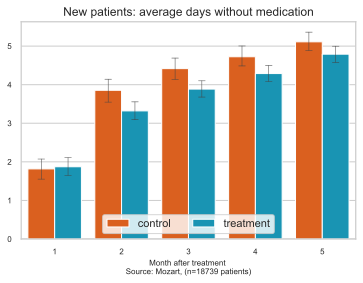

In [20]:
#.query("days_without_med < 30")
import matplotlib.pyplot as plt
g = sns.barplot(panel_all, x="period",
             y="days_without_med",
             hue="treatment_status", errorbar=("ci",95),
             palette=palette_anc, 
             hue_order=order,errwidth=0.5, capsize=0.1)
#plt.title("Novos pacientes (30): média de dias sem medicação")
plt.title("New patients: average days without medication")

plt.ylabel("")
#plt.xlabel("Mês após a intervenção \n" + source_new, fontsize=8)
plt.xlabel("Month after treatment \n" + source_new, fontsize=8)

format_graph(g)

plt.savefig(f"{img}/adm_new_days_without.jpeg", bbox_inches='tight',dpi=300)
plt.show()

#### new: delay for those who come back

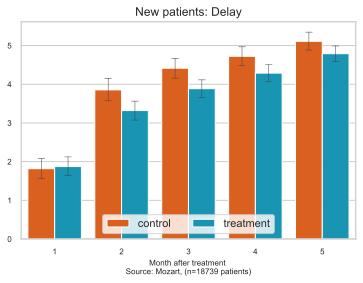

In [60]:
g = sns.barplot(panel_all, x="period",
             y="days_without_med",
             hue="treatment_status", errorbar=("ci",95),
             palette=palette_anc, 
             hue_order=order,errwidth=0.5, capsize=0.1)

plt.ylabel("")
plt.xlabel("Mês após a intervenção \n" + source_new, fontsize=8)
plt.xlabel("Month after treatment \n" + source_new, fontsize=8)
format_graph(g)

plt.title("Novos pacientes: Média de dias de atraso")
plt.title("New patients: Delay")

plt.savefig(f"{img}/adm_new_delay.jpeg", bbox_inches='tight',dpi=300)
plt.show()

### mpr  

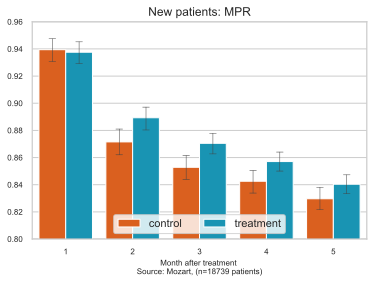

In [59]:
g = sns.barplot(panel_all, x="period",
             y="mpr",
             hue="treatment_status", errorbar=("ci",95),
             palette=palette_anc, 
             hue_order=order,errwidth=0.5, capsize=0.1)
plt.title("Novos pacientes: MPR")
plt.title("New patients: MPR")
plt.ylim([0.8,0.96])
format_graph(g)
plt.ylabel("")
plt.xlabel("Mês após a intervenção \n" + source_new, fontsize=8)
plt.xlabel("Month after treatment \n" + source_new, fontsize=8)

plt.savefig(f"{img}/adm_new_mpr.jpeg", bbox_inches='tight',dpi=300)
plt.show()

#### new: delay >= 7

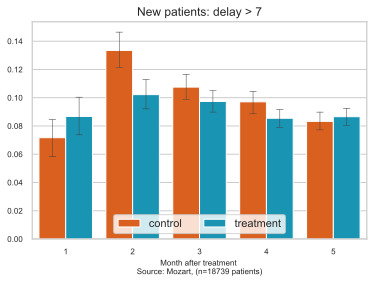

In [62]:
g = sns.barplot(panel_all, x="period",
             y="delay_7",
             hue="treatment_status", errorbar=("ci",95),
             palette=palette_anc, 
             hue_order=order,errwidth=0.5, capsize=0.1)
plt.title("Novos pacientes: Atraso > 7")
plt.title("New patients: delay > 7")
format_graph(g)
plt.ylabel("")
plt.xlabel("Mês após a intervenção \n" + source_new, fontsize=8)
plt.xlabel("Month after treatment \n" + source_new, fontsize=8)

plt.savefig(f"{img}/adm_new_delay_7.jpeg", bbox_inches='tight',dpi=300)
plt.show()

### graph old cohort

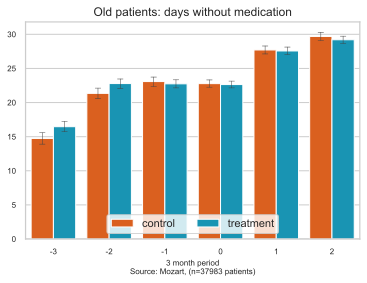

In [63]:
g = sns.barplot(panel_old, x="period",
             y="days_without_med",
             hue="treatment_status", errorbar=("ci",95),
             palette=palette_anc, 
             hue_order=order,errwidth=0.5, capsize=0.1)
plt.title("Pacientes antigos: dias sem medicação")
plt.title("Old patients: days without medication")

plt.xlabel("Períodos de 3 meses agrupados \n" + source_old, fontsize=8)
plt.xlabel("3 month period\n" + source_old, fontsize=8)
plt.ylabel("")

format_graph(g)

plt.savefig(f"{img}/adm_old_days_without.jpeg", bbox_inches='tight',dpi=300)
plt.show()

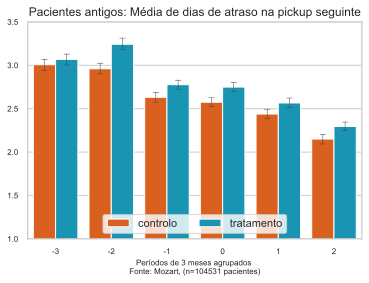

In [32]:
g = sns.barplot(panel_old.query("days_without_med < 30"), x="period",
             y="days_without_med",
             hue="treatment_status", errorbar=("ci",95),
             palette=palette_anc, 
             hue_order=order,errwidth=0.5, capsize=0.1)
plt.title("Old patients: delay")
plt.title("Pacientes antigos: Média de dias de atraso na pickup seguinte")
plt.xlabel("3 month period\n" + source_old, fontsize=8)
plt.xlabel("Períodos de 3 meses agrupados \n" + source_old, fontsize=8)

plt.ylabel("")

format_graph(g)
plt.ylim([1,3.5])

plt.savefig(f"{img}/adm_old_delay.jpeg", bbox_inches='tight',dpi=300)
plt.show()

#### old patients mpr

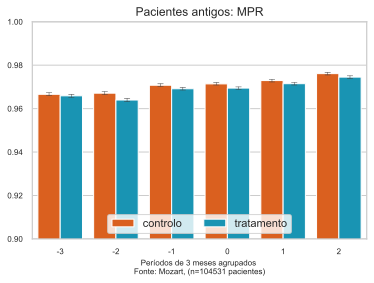

In [33]:
g = sns.barplot(panel_old.query("days_without_med < 30"), x="period",
             y="mpr",
             hue="treatment_status", errorbar=("ci",95),
             palette=palette_anc, 
             hue_order=order,errwidth=0.5, capsize=0.1)
plt.xlabel("3 month period\n" + source_old, fontsize=8)
plt.xlabel("Períodos de 3 meses agrupados \n" + source_old, fontsize=8)

plt.ylabel("")

format_graph(g)
plt.title("Old patients: MPR (excluding dropouts)")
plt.title("Pacientes antigos: MPR")

plt.ylim([0.9,1])

plt.savefig(f"{img}/adm_old_mpr.jpeg", bbox_inches='tight',dpi=300)
plt.show()

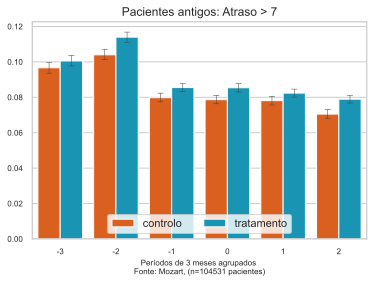

In [34]:
panel_old.loc[panel_old["days_without_med"].notnull(),"delay_7"] = 0
filter_7_29 = panel_old["days_without_med"].between(8,29,inclusive="both")
panel_old.loc[filter_7_29, "delay_7"] = 1

g = sns.barplot(panel_old, x="period",
             y="delay_7",
             hue="treatment_status", errorbar=("ci",95),
             palette=palette_anc,
             hue_order=order,errwidth=0.5, capsize=0.1)
plt.title("Old patients: delay > 7 (excluding dropouts)")
plt.title("Pacientes antigos: Atraso > 7")
plt.xlabel("3 month period\n" + source_old, fontsize=8)
plt.xlabel("Períodos de 3 meses agrupados \n" + source_old, fontsize=8)

plt.ylabel("")
format_graph(g)
plt.ylabel("")

plt.savefig(f"{img}/adm_old_days_7.jpeg", bbox_inches='tight',dpi=300)
plt.show()

In [ ]:
path_mozart = "/Users/rafaelfrade/arquivos/desenv/lse/adm_data/mozart"
gaac = pd.read_csv(f"{path_mozart}⁄t_adulto.csv")

### new patients by month

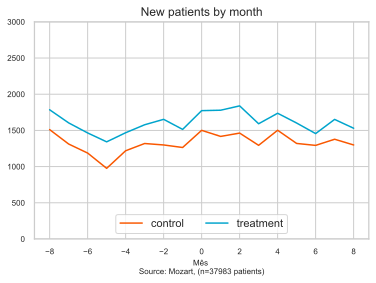

In [27]:
new_by_month = adm.query("pickup_order_from_first == 1")
count_new = (new_by_month.groupby(["treatment_status","month_order"])
    .size()
    .reset_index()
    .rename(columns={0:"n_pickups"})
    .query("month_order.between(-8,8)"))

g = sns.lineplot(count_new,
            x="month_order",y="n_pickups",
             hue="treatment_status",
             palette=palette_anc,
             hue_order=order)

plt.xlabel("Mês \n" + source_old, fontsize=8)
plt.ylabel("")
format_graph(g)
plt.ylabel("")
plt.title("Novos pacientes por mês")
plt.title("New patients by month")
plt.ylim([0, 3000])

plt.savefig(f"{img}/adm_new_by_month.jpeg", bbox_inches='tight',dpi=300)
plt.show()

## Qtt by month

In [ ]:
new = adm.query("new_patient == 1 & month_order <= 8")
count_new = (new.groupby(["treatment","month_order"])
    .size()
    .reset_index()
    .rename(columns={0:"n_pickups"}))

sns.lineplot(count_new, x="month_order",y="n_pickups",hue="treatment")
plt.title("New patients: total pickups by month")
#plt.ylim([0,7000])
plt.show()

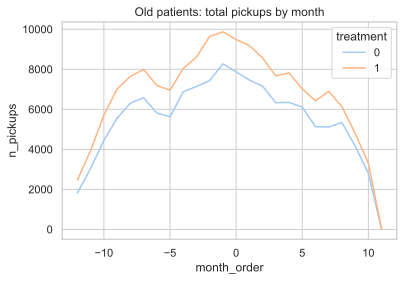

In [43]:
count_new = (old.groupby(["treatment","month_order"])
    .size()
    .reset_index()
    .rename(columns={0:"n_pickups"}))

sns.lineplot(count_new, x="month_order",y="n_pickups",hue="treatment")
plt.title("Old patients: total pickups by month")

plt.show()

### Loss to follow up

In [58]:
new_last = adm.query("new_patient == 1")

new_last.loc[:, "remaining_pickups"] = (new_last.sort_values("pick_up")
    .groupby("nid")["pick_up"]
 .rank(ascending=False).add(-1))

new_last["last_pickup"] = 0
new_last.loc[new_last["remaining_pickups"] == 0, "last_pickup"] = 1

g = sns.barplot(new_last.query("month_order.between(1,5)"),
            x="month_order", y="last_pickup",
            hue="treatment_status",
            palette=palette_anc,
            hue_order=order,errwidth=0.5, capsize=0.1)
plt.title("Novos pacientes: perda de seguimento")
plt.title("New patients: loss to follow up")
plt.xlabel("Mês \n" + source_new, fontsize=8)
plt.xlabel("Month \n" + source_new, fontsize=8)
plt.ylabel("")
format_graph(g)
plt.ylabel("")

plt.savefig(f"{img}/adm_new_loss.jpeg", bbox_inches='tight',dpi=300)
plt.show()

NameError: name 'palette_anc' is not defined

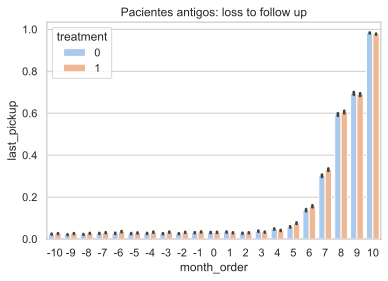

In [46]:
old_last = adm.query("new_patient == 0")

old_last.loc[:, "remaining_pickups"] = (old_last.sort_values("pick_up")
    .groupby("nid")["pick_up"]
 .rank(ascending=False))

old_last["last_pickup"] = 0
old_last.loc[old_last["remaining_pickups"] == 1, "last_pickup"] = 1

sns.barplot(old_last.query("month_order.between(-10,10)"),
            x="month_order", y="last_pickup",
            hue="treatment")
plt.title("Old patients: loss to follow up")
plt.title("Pacientes antigos: loss to follow up")

plt.savefig(f"{img}/adm_new_loss.jpeg", bbox_inches='tight',dpi=300)
plt.show()

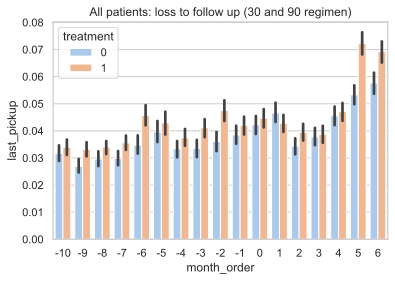

In [50]:
old_last = adm
old_last.loc[:, "remaining_pickups"] = (old_last.sort_values("pick_up")
    .groupby("nid")["pick_up"]
 .rank(ascending=False))

old_last["last_pickup"] = 0
old_last.loc[old_last["remaining_pickups"] == 1, "last_pickup"] = 1

sns.barplot(old_last.query("month_order.between(-10,6) & maputo == 1"),
             x="month_order", y="last_pickup",
            hue="treatment")
plt.title("All patients: loss to follow up (30 and 90 regimen)")
plt.show()

## loss to follow-up 1st 4 months

In [65]:
new_last = new_last.set_index("nid")
new_last["loss"] = 0
query_loss_tfu = "remaining_pickups == 0 & month_order <= 4"

index_loss = new_last.query(query_loss_tfu).index
new_last.loc[index_loss,"loss"] = 1
new_last = new_last.reset_index()

(new_last.query("month_order <= 4").groupby("nid").last()
    .groupby(["treatment"])["loss"]
 .value_counts(normalize=True))

treatment  loss
0          0       0.843881
           1       0.156119
1          0       0.862849
           1       0.137151
Name: proportion, dtype: float64

In [67]:
#cols_to_drop = ["adu_nid_spouse","pac_code_referred_other"]
#(new_patients_4months.reset_index()
#     .dropna(axis=1,how='all')
#     .drop(cols_to_drop,axis=1)
#    .to_stata(f"{path_panel}/new_patients_5months.dta"))

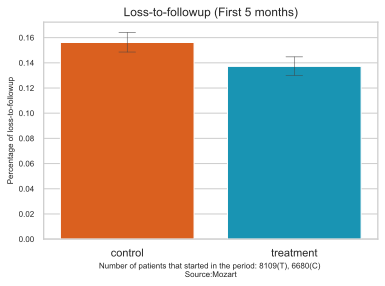

In [70]:
new_patients_4months= new_last.query("month_order <= 4").groupby("nid").first()
sns.barplot(new_patients_4months,
            x="treatment_status", y="loss",
            palette=palette_anc, order=order,errwidth=0.5, capsize=0.1)
plt.title("Abandono de tratamento nos primeiros 5 meses após a intervenção")
plt.title("Loss-to-followup (First 5 months)")
xlabel = "Iniciaram o tratamento no período: 8109(Tratamento), 6680(Controlo) \n"+"Fonte:Mozart"
xlabel = "Number of patients that started in the period: 8109(T), 6680(C) \n"+"Source:Mozart"

plt.xlabel(xlabel,
           fontsize=8)
plt.ylabel("Percentual de abondono de tratamento", fontsize=8)
plt.ylabel("Percentage of loss-to-followup", fontsize=8)
plt.savefig(f"{img}/adm_loss_5_months", bbox_inches='tight', dpi=300)
plt.yticks(fontsize=8)
plt.show()

## Painel without dropouts

In [139]:
nid_dropouts = (new_last[new_last
         .eval("last_pickup == 1 & month_order <= 5")]
    ["nid"])
panel_30_no_dropouts = (panel_30.loc[
                        ~panel_30["nid"].isin(nid_dropouts)])
panel_all_no_dropouts = (panel_all.loc[
                        ~panel_all["nid"].isin(nid_dropouts)])


path_panel = "/Users/rafaelfrade/arquivos/desenv/lse/adm_data/art_intervention/panel/"

panel_30_no_dropouts.to_stata(f"{path_panel}/panel_new_30_no_drop.dta")

panel_all_no_dropouts.to_stata(f"{path_panel}/panel_all_30_no_drop.dta")

## Heterogeneity

In [34]:
def column_by_quantile(df, col, n_quantiles,n_round=2,format_int=True):
    """
        Divide the column in quantiles and generate a label
    """
    quantiles = np.linspace(0,1,n_quantiles+1)

    conditions = []
    labels = []
    for i,q in enumerate(quantiles[0:(n_quantiles)]):
        v = np.quantile(df[col], q)
        v_next = np.quantile(df[col], quantiles[i+1])
        
        # if last, changes comparison to lower or equal
        if i == n_quantiles-1:
            conditions.append( (df[col] >= v) & (df[col] <= v_next) )
        else:
            conditions.append( (df[col] >= v) & (df[col] < v_next) )
    
        if format_int:
            lower_bound = int(round(v,n_round))
            upper_bound = int(round(v_next,n_round))
        else:
            lower_bound = round(v,n_round)
            upper_bound = round(v_next,n_round)
            
        label = f"{lower_bound}-{upper_bound}"
        labels.append(label)
    
    return np.select(conditions, labels),labels

In [52]:
path_fac_char = "/Users/rafaelfrade/arquivos/desenv/lse/anc_rct/data/"
facility_info = pd.read_stata(f"{path_fac_char}/facility_characteristics.dta")

#### PCA Quality
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
cols_pca = ["score_basic_amenities",
            #"score_basic_equipment",
            "index_general_service",
            "index_HIV_care_readiness"]
pca.fit(facility_info.query("facility_cod != 36")[cols_pca])
not_36 = facility_info.eval("facility_cod != 36")
facility_info.loc[not_36, "pca_quality"] = pca.transform(facility_info[not_36][cols_pca])

#### VOLUME
facility_info["pat_per_day"] = (adm
                                .query("month_order.between(-3,1, inclusive='both')")
                                .groupby("facility_cod")
                                .size()
                                .div(90)
                                .round()
                                .reset_index()[0])

panel_new = panel_all.merge(facility_info, on="facility_cod",
                suffixes=('', '_y'))
panel_new["vol_groups"],labels_vol = column_by_quantile(panel_new,
                                                        "pat_per_day",
                                                        4,0)

### QUALITY/INFRA PCA
not_36 = panel_new.eval("facility_cod != 36")
pca_groups,labels_pca = column_by_quantile(panel_new[not_36],
                                                        "pca_quality",
                                                        3,2, format_int=False)
panel_new.loc[not_36,"pca_groups"] = pca_groups
new_label_quality = {"pca_groups": {labels_pca[0]: "Low",
                            labels_pca[1]: "Medium",
                            labels_pca[2]: "High"}}
labels_pca = {"Low","Medium","High"}
panel_new.replace(new_label_quality , inplace = True)

### DATA BY PATIENT
new_patients = new_last.query("month_order <= 4").groupby("nid").first()
new_patients = new_patients.drop("pat_per_day",axis=1,
                                 errors='ignore')

new_patients_het = new_patients.merge(facility_info[["facility_cod",
                                                     "pat_per_day",
                                                     "pca_quality"]],
                                      on="facility_cod",how="left")
new_patients_het["vol_groups"],labels_vol_pat = column_by_quantile(new_patients_het,
                                                        "pat_per_day",
                                                        4,0)

not_36 = new_patients_het.eval("facility_cod != 36")
pca_groups_het,labels_pca_pat = column_by_quantile(new_patients_het[not_36],
                                                        "pca_quality",
                                                        3,2,format_int=False)
new_patients_het.loc[not_36,"pca_groups"]=pca_groups_het
new_patients_het.replace(new_label_quality, inplace = True)

In [36]:
SOURCE_NEW_5_MONTHS = "Fonte: Mozart (15855 pacientes)"
#0    7142
#1    8713


def plot_het_graph(df,x,y,labels):
    g = sns.barplot(df, x=x,
            y=y, hue="treatment_status",
            order=labels,errorbar=("ci",95),
            palette=palette_anc,
            hue_order=order,errwidth=0.5, capsize=0.1)
    format_graph(g)
    return g

#### quality

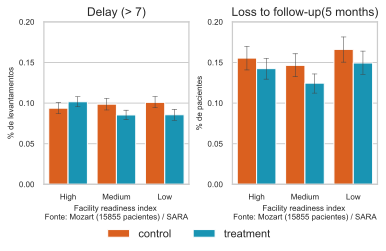

In [41]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)

g = plot_het_graph(panel_new,x="pca_groups",
            y="delay_7",labels=labels_pca)
plt.xlabel("Índice de preparo/infraestrutura da US \n" + SOURCE_NEW_5_MONTHS + " / SARA",
           fontsize=8)
plt.xlabel("Facility readiness index \n" + SOURCE_NEW_5_MONTHS + " / SARA",
           fontsize=8)
plt.ylabel("% de levantamentos", fontsize=8)
plt.title("Atraso de 7 dias ou mais")
plt.title("Delay (> 7)")
plt.ylim([0,0.2])
sns.move_legend(g,loc='lower center', ncol=2, title="", frameon=False,
               bbox_to_anchor=(1, -.4))

plt.subplot(1, 2, 2)
plot_het_graph(new_patients_het,x="pca_groups",
               y="loss",labels=labels_pca)
plt.ylabel("% de pacientes", fontsize=8)
plt.title("Abandono do tratamento \n nos 5 primeiros meses")
plt.title("Loss to follow-up(5 months)")
plt.legend([],[], frameon=False)
plt.ylim([0,0.2])
plt.xlabel("Índice de preparo/infraestrutura da US \n" + SOURCE_NEW_5_MONTHS + " / SARA",
           fontsize=8)
plt.xlabel("Facility readiness index \n" + SOURCE_NEW_5_MONTHS + " / SARA",
           fontsize=8)

plt.subplots_adjust(wspace=0.3)
plt.savefig(f"{img}/het_hiv_infra", bbox_inches='tight',dpi=300)
plt.show()

#### age

In [49]:
len(age_group)

15842

ValueError: Length of values (15842) does not match length of index (15855)

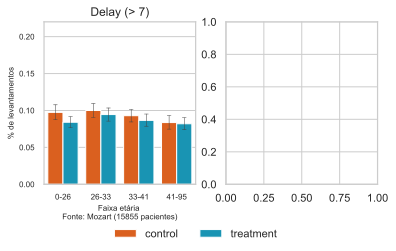

In [50]:
#import numpy as np
#np.quantile(means_new["pac_age"], 0.75)
outcome_cols=["delay_7","days_without_med","mpr"]

means_new = (panel_all.dropna(subset=["days_without_med"])
    .groupby("nid")[outcome_cols].mean()
    .reset_index())

new_het = (adm.query("new_patient == 1")
    [["nid","pac_sex","pac_age","treatment_status"]]
        .drop_duplicates())
means_new = means_new.merge(new_het, left_on="nid", 
                            right_on="nid",how="left")

age_group,label_age = column_by_quantile(means_new,"pac_age",4,1)
means_new["age_group"] = age_group

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)

g = plot_het_graph(means_new,x="age_group",
            y="delay_7",labels=label_age)
plt.xlabel("Faixa etária \n" + SOURCE_NEW_5_MONTHS, fontsize=8)
plt.ylabel("% de levantamentos", fontsize=8)
plt.title("Atraso de 7 dias ou mais")
plt.title("Delay (> 7)")
sns.move_legend(g,loc='lower center', ncol=2, title="", frameon=False,
               bbox_to_anchor=(1, -.4))
plt.ylim([0,0.22])

plt.subplot(1, 2, 2)
age_group,label_age = column_by_quantile(means_new,"pac_age",4,1)
new_patients_het["age_group"] = age_group

plot_het_graph(new_patients_het,x="age_group",
            y="loss",labels=label_age)
plt.xlabel("Faixa etária \n" + SOURCE_NEW_5_MONTHS, fontsize=8)
plt.ylabel("% de levantamentos", fontsize=8)
plt.title("Abandono do tratamento \n nos 5 primeiros meses")
plt.title("Loss to follow-up(5 months)")

plt.legend([],[], frameon=False)
plt.ylabel("% de pacientes",fontsize=8)
plt.ylim([0,0.22])
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"{img}/het_hiv_age", bbox_inches='tight',dpi=300)
plt.show()

#### volume

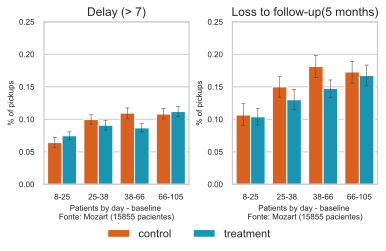

In [54]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
g = plot_het_graph(panel_new,x="vol_groups",
               y="delay_7",labels=labels_vol)

plt.xlabel("Pacientes por dia - baseline \n" + SOURCE_NEW_5_MONTHS,
           fontsize=8)
plt.xlabel("Patients by day - baseline \n" + SOURCE_NEW_5_MONTHS,
           fontsize=8)
plt.ylabel("% of pickups", fontsize=8)
plt.title("Atraso acima de 7 dias")
plt.title("Delay (> 7)")
sns.move_legend(g,loc='lower center', ncol=2, title="", frameon=False,
               bbox_to_anchor=(1, -.4))
plt.ylim([0,0.25])

plt.subplot(1, 2, 2)
g = plot_het_graph(new_patients_het, x="vol_groups",
               y="loss",labels=labels_vol_pat)
plt.legend([],[], frameon=False)
plt.ylim([0,0.25])

plt.xlabel("Pacientes por dia - baseline \n" + SOURCE_NEW_5_MONTHS,
           fontsize=8)
plt.xlabel("Patients by day - baseline \n" + SOURCE_NEW_5_MONTHS,
           fontsize=8)
plt.title("Abandono do tratamento \n nos 5 primeiros meses")
plt.title("Loss to follow-up(5 months)")
plt.ylabel("% of pickups", fontsize=8)
plt.subplots_adjust(wspace=0.3)

plt.savefig(f"{img}/het_hiv_vol", bbox_inches='tight',dpi=300)
plt.show()



# data_merge_pre_stata e data_refill

In [442]:
path_raw_data = "/Users/rafaelfrade/arquivos/desenv/lse/adm_data/notebooks/data"
pre_stata = pd.read_csv(f"{path_raw_data}/data_merge_pre_stata.csv",
                        sep="\t")
refill = pd.read_csv(f"{path_raw_data}/_data_refill.csv",
                        sep="\t")

pre_stata["pickup"] = pd.to_datetime(pre_stata["trv_date_pickup_drug"],format="%Y-%m-%d")
refill["pickup"] = pd.to_datetime(refill["trv_date_pickup_drug"],format="%Y-%m-%d")

pre_stata = pre_stata.sort_values(["nid","pickup"])
refill = refill.sort_values(["nid","pickup"])

<ipython-input-442-6eacb794983f>:2: DtypeWarning: Columns (11,24,25,28,33,46,47,49,51,52,63,64,65,71,74,75,76,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  pre_stata = pd.read_csv(f"{path_raw_data}/data_merge_pre_stata.csv",
<ipython-input-442-6eacb794983f>:4: DtypeWarning: Columns (11,24,25,33,51,52,53,63,65,71,74,80,81,83) have mixed types. Specify dtype option on import or set low_memory=False.
  refill = pd.read_csv(f"{path_raw_data}/_data_refill.csv",


In [478]:
(refill.query("nid == '0111030701/2017/01848' ")
    [["pickup","trv_actual_next_pickup","trv_expected_next_pickup"]])

,pickup,trv_actual_next_pickup,trv_expected_next_pickup
944181,2017-10-19,2017-11-28,2017-11-17
944182,2017-11-28,2017-12-22,2017-12-27
944183,2017-12-22,2018-01-31,2018-01-23
944184,2018-01-31,2018-03-06,2018-03-01
944185,2018-03-06,2018-04-05,2018-04-04
944186,2018-04-05,2018-05-04,2018-05-04
944187,2018-05-04,2018-06-04,2018-06-01
944188,2018-06-04,2018-07-04,2018-07-04
944189,2018-07-04,2018-08-06,2018-08-03
944190,2018-11-13,2018-12-10,2018-12-13


In [479]:
(pre_stata.query("nid == '0111030701/2017/01848' ")
    [["pickup","trv_actual_next_pickup","trv_expected_next_pickup"]])

,pickup,trv_actual_next_pickup,trv_expected_next_pickup
2030351,2017-09-18,2017-10-19,2017-10-11
2030352,2017-10-19,2017-11-28,2017-11-17
2030353,2017-11-28,2017-12-22,2017-12-27
2030354,2017-12-22,2018-01-31,2018-01-23
2030355,2018-01-31,2018-03-06,2018-03-01
2030356,2018-03-06,2018-04-05,2018-04-04
2030357,2018-04-05,2018-05-04,2018-05-04
2030358,2018-05-04,2018-06-04,2018-06-01
2030359,2018-06-04,2018-07-04,2018-07-04
2030360,2018-07-04,2018-08-06,2018-08-03


In [480]:
(adm.query("nid == '0111030701/2017/01848' ")
    [["pick_up"]]).sort_values("pick_up")

,pick_up
27652853,2019-07-17
27652854,2019-08-21
27652855,2019-09-27
27652836,2020-10-26
27652835,2020-11-26
27862321,2021-01-29
27862318,2021-02-09
27862322,2021-06-22
27862320,2021-07-23
27862319,2021-08-30


### T_ADULTO

In [333]:
#adm["fever_1_months"]

In [299]:
path_mozart = "/Users/rafaelfrade/arquivos/desenv/lse/adm_data/mozart"
df = pd.read_csv(f"{path_mozart}/t_paciente.csv")

In [301]:
seguimento = pd.read_csv(f"{path_mozart}/t_seguimento.csv")
seguimento = seguimento[~seguimento["dataseguimento"].str.contains('201-')]

<ipython-input-301-dc24f2bf7e06>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  seguimento = pd.read_csv(f"{path_mozart}/t_seguimento.csv")


#### volume by day

#### 6 month loss to follow-up

In [372]:
new_4 = adm.query("new_patient == 1 & month_order <= 4").sort_values("pick_up")

new_4.loc[:, "remaining_pickups"] = (new_4
    .groupby("nid")["pick_up"]
 .rank(ascending=False).add(-1))

new_4["last_pickup"] = 0
new_4.loc[new_4["remaining_pickups"] == 0, "last_pickup"] = 1

(new_4.groupby(["treatment","month_order"])
    ["last_pickup"].sum())

treatment  month_order
0          0               107
           1               235
           2               377
           3               929
           4              5032
1          0               140
           1               253
           2               440
           3              1030
           4              6246
Name: last_pickup, dtype: int64

In [395]:
new_4.query("month_order == 0")["last_pickup"].sum()

187

In [392]:
new_4 = adm.query("new_patient == 1").sort_values("pick_up")

new_4.loc[:, "remaining_pickups"] = (new_4
    .groupby("nid")["pick_up"]
 .rank(ascending=False).add(-1))

new_4["last_pickup"] = 0
new_4.loc[new_4["remaining_pickups"] == 0, "last_pickup"] = 1

(new_4.groupby(["treatment","month_order"])
    ["last_pickup"].sum())

treatment  month_order
0          0                83
           1               165
           2               197
           3               264
           4               365
           5               374
           6               560
           7              1005
           8              2527
           9              3186
           10             4909
1          0               104
           1               166
           2               243
           3               264
           4               343
           5               386
           6               650
           7              1563
           8              3260
           9              3672
           10             5501
           11               21
Name: last_pickup, dtype: int64

In [368]:
# & month_order.between(-15,4)
old_4 = adm.query("new_patient == 0").sort_values("pick_up")

old_4.loc[:, "remaining_pickups"] = (old_4
    .groupby("nid")["pick_up"]
 .rank(ascending=False).add(-1))

old_4["last_pickup"] = 0
old_4.loc[old_4["remaining_pickups"] == 0, "last_pickup"] = 1

(old_4.groupby(["treatment","month_order"])
    ["last_pickup"].sum())

treatment  month_order
0          -18              111
           -17              261
           -16              614
           -15              547
           -14              588
           -13              611
           -12              611
           -11              589
           -10              635
           -9               554
           -8               575
           -7               575
           -6               485
           -5               471
           -4               518
           -3               516
           -2               567
           -1               606
            0               647
            1               692
            2               559
            3               661
            4               953
            5              1127
            6              2426
            7              6163
            8             11250
            9              9297
            10             7750
            11               10
1          -18   

In [387]:
(adm.query("nid == '0110051401/2019/00278'")
    .sort_values("pick_up")
    [["pick_up","month_order","qtt", "adu_number_kids"]])

,pick_up,month_order,qtt,adu_number_kids
1471127,2019-12-30,-11,30.0,NaN
1471124,2020-01-29,-10,30.0,NaN
1471122,2020-02-04,-9,30.0,NaN
1471128,2020-03-03,-8,30.0,NaN
1471123,2020-04-06,-7,30.0,NaN
1471125,2020-05-06,-6,30.0,NaN
1471126,2020-06-05,-5,90.0,NaN
1471129,2020-09-01,-2,90.0,NaN
26769942,2020-12-03,1,90.0,NaN
26769941,2021-02-23,4,90.0,NaN


In [339]:

sns.barplot(new_last.query("month_order.between(1,6)"),
            x="month_order", y="last_pickup",
            hue="treatment")
plt.title("New patients: loss to follow up (30 and 90 regimen)")
plt.show()

#### Heterogeneity